In [3]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# Gaussian Processes

$y_{*} \sim {\cal N} \left (\mu(\mathbf{x}_*), \sigma(\mathbf{x}_*) \right )$\
$\mu(\mathbf{x}_*) = k(\mathbf{x}_*,\mathbf{X})^\top \left (K(\mathbf{X},\mathbf{X}) +\sigma_n\mathbb{I} \right )^{-1}\mathbf{y}$\
$\sigma(\mathbf{x}_*) = k(\mathbf{x}_*,\mathbf{x}_*) - k(\mathbf{x}_*,\mathbf{X})^\top \left (K(\mathbf{X},\mathbf{X}) +\sigma_n\mathbb{I} \right )^{-1}k(\mathbf{x}_*,\mathbf{X})$


## Let's fit a PES for N2 molecule 

Data was generated using 
```python

from pyscf import gto, scf, mcscf, dft
import numpy as np

def get_energy(r): 
  # r  is the N-N distance in the z-axis
  mol = gto.M(atom='N 0 0 0; N 0 0 %.3f'%(r), basis='6-311g')
  mf = dft.RKS(mol, xc="b3lyp").density_fit().run()
  energy = mf.kernel()
  return energy
```

Text(0, 0.5, 'Energy')

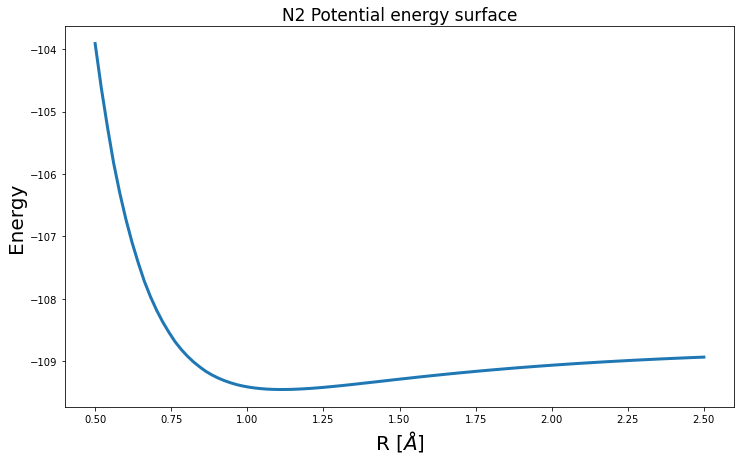

In [130]:
data_url = "https://github.com/RodrigoAVargasHdz/CHEM-4PB3/raw/main/Course_Notes/data/PES_N2"
data = pd.read_csv(data_url)

plt.figure(figsize=(12,7))
plt.plot(data['R'], data['Energy'],lw=3.)
plt.title('N2 Potential energy surface',fontsize=17)
plt.xlabel(r'R [$\AA$]',fontsize=20)
plt.ylabel('Energy',fontsize=20)

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct,\
    RBF, WhiteKernel, Matern, ExpSineSquared
from sklearn.model_selection import train_test_split

In [107]:
# select random data
X,y = data['R'].to_numpy(), data['Energy'].to_numpy()
X = X[:,np.newaxis] #(N,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=1)

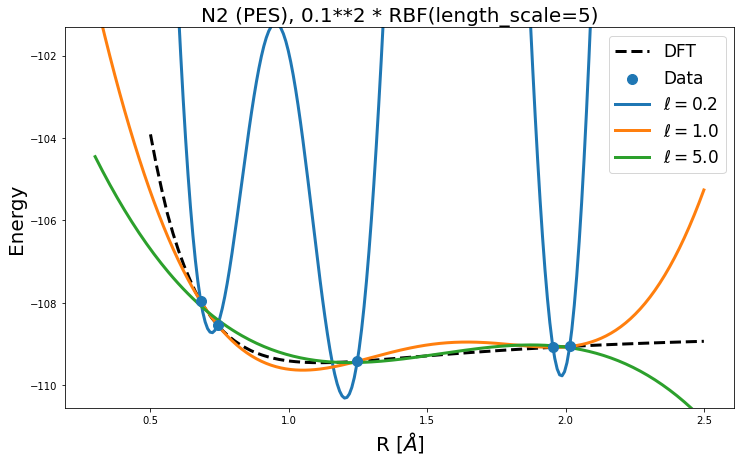

In [185]:
# GP
x_grid = np.linspace(0.3,2.5,250)[:,np.newaxis]

plt.figure(figsize=(12,7))
plt.plot(X, y,ls='--',c='k',lw=3.,label = 'DFT')
plt.scatter(X_train,y_train,marker='o',\
            c='tab:blue',s=100,label='Data',zorder=3.5)

l = np.array([0.25, 1., 5.])
for li in l:
    kernel = 0.01 * \
        RBF(length_scale=li, length_scale_bounds=(1E-3, 1E2))      
    model = GaussianProcessRegressor(kernel=kernel, optimizer=None)
    model.fit(X_train, y_train)
    y_pred = model.predict(x_grid)
    plt.plot(x_grid, y_pred, lw=3.,\
        label=r'$\ell = %.1f$' % li)
    
plt.ylim(np.min(y)*1.01, np.max(y)*0.975)
plt.legend(fontsize=17)
plt.title('N2 (PES), %s'%model.kernel_, fontsize=20)
plt.xlabel(r'R [$\AA$]', fontsize=20)
plt.ylabel('Energy', fontsize=20)
plt.savefig('Figures/N2_PES_gp_rbf_l.png',dpi=900)

From the figure above we can observe that for the RBF kernel,\
$k_{RBF}(x_i,x_j) = \exp\left( -(x_i - x_j)^2/2{\color{blue}\ell}^2\right )$\
the length-scale parameter ${\color{blue}\ell}$ is fundamental in the accuracy.

## Marginal likelihood

$\log p(\mathbf{y} | \mathbf{X}) =  -\frac{1}{2} \mathbf{y}^\top\left(K +\lambda\mathbb{I} \right)^{-1}\mathbf{y}  -\frac{1}{2} \log \left | K+\lambda\mathbb{I}\right | -\frac{N}{2}\log(2\pi)$\
* It represents the probability of generating the observed sample from a prior and is therefore often referred to as model evidence or simply evidence. 

Let's considered the following kernel\
From the figure above we can observe that for the RBF kernel,\

$k_{RBF}(x_i,x_j) = {\color{blue}c}\exp\left(-(x_i - x_j)^2/2{\color{blue}\ell}^2\right )$\

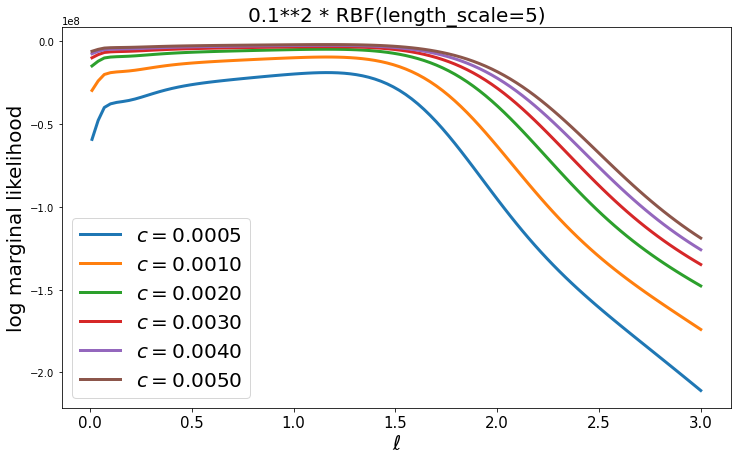

In [195]:
def get_mll_curve(c):
    l_ = np.linspace(0.01,3.,100) # grid over lenght-scale parameter
    mll_ = []

    for li in l_:
        kernel = c * \
            RBF(length_scale=li, length_scale_bounds=(1E-3, 1E2))
        model = GaussianProcessRegressor(kernel=kernel, optimizer=None)
        model.fit(X_train, y_train)
        mll = model.log_marginal_likelihood()
        mll_.append(mll)
    return np.array(mll_), l_

# grid over the c-parameter
c = np.array([0.0005,0.001,0.002,0.003,0.004,0.005])

plt.figure(figsize=(12, 7))
for ci in c: 
    mll_, l_ = get_mll_curve(ci)
    plt.plot(l_,mll_,label=r'$c = %.4f$'%ci,lw=3.)

plt.title('%s' % model.kernel_, fontsize=20)
plt.xlabel(r'$\ell$', fontsize=20)
plt.ylabel('log marginal likelihood', fontsize=20)
plt.xticks(fontsize=15)
plt.legend(fontsize=20)
plt.savefig('Figures/mll_rbf.png',dpi=900)

In [172]:
#Optimal value of the parameters

kernel = ConstantKernel(1.) * \
    RBF(length_scale=1., length_scale_bounds=(1E-3, 1E2))
model = GaussianProcessRegressor(kernel=kernel)
model.fit(X_train, y_train)



1**2 * RBF(length_scale=1)


## Homework!
Fit the H3O+ PES.

[Data]()

**References**:\
[Assessing Gaussian Process Regression and Permutationally Invariant Polynomial Approaches To Represent High-Dimensional Potential Energy Surfaces](https://pubs.acs.org/doi/10.1021/acs.jctc.8b00298)